In [47]:
# Cell 1: 匯入必要模組
import os
import yaml

# Cell 2: 設定目錄路徑
rag_dir = "/home/aiml/johnson/auto_gen_debug_yaml/debug_yaml_dir/rag"
none_rag_dir = "/home/aiml/johnson/auto_gen_debug_yaml/debug_yaml_dir/none_rag"
# Cell 3: 處理單一 YAML 檔案，回傳 notes 條目列表

def clean_llm_output(raw_output: str) -> str:
    """
    Remove markdown-style code block wrapper from LLM output
    """
    if raw_output.startswith("```json"):
        # Remove ```json and ending ```
        return re.sub(r"^```json\s*|\s*```$", "", raw_output.strip(), flags=re.IGNORECASE).strip()
    return raw_output.strip()

def extract_notes_from_file(filepath):
    notes_list = []
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            content = yaml.safe_load(f)

        if isinstance(content, list):
            for idx, entry in enumerate(content):
                if not isinstance(entry, dict):
                    print(f"⚠️ Skipped non-dict entry in {filepath}: {entry}")
                    continue  # 跳過格式錯誤的項目

                note = entry.get("notes", "").strip()
                if note:
                    notes_list.append({
                        "file": os.path.basename(filepath),
                        "index": idx,
                        "stage": entry.get("stage", "N/A"),
                        "type": entry.get("type", "N/A"),
                        "notes": note
                    })
        else:
            print(f"⚠️ Unexpected YAML root type in {filepath}: {type(content)}")

    except Exception as e:
        print(f"⚠️ Error reading {filepath}: {e}")
    return notes_list


# Cell 4: 掃描所有檔案並整理 notes
rag_all_notes = []
none_rag_all_notes = []


for filename in os.listdir(rag_dir):
    if filename.endswith(".yaml"):
        full_path = os.path.join(rag_dir, filename)
        notes = extract_notes_from_file(full_path)
        rag_all_notes.extend(notes)

# Cell 5: 印出結果
for note in rag_all_notes:
    print(f"📄 File: {note['file']} ({note['stage']} - {note['type']})")
    print(note['notes'])
    print("-" * 100)
    
print("\n")
print("-" * 1000)
print("-" * 1000)
print("\n")

for filename in os.listdir(none_rag_dir):
    if filename.endswith(".yaml"):
        full_path = os.path.join(none_rag_dir, filename)
        notes = extract_notes_from_file(full_path)
        none_rag_all_notes.extend(notes)

# Cell 5: 印出結果
for note in none_rag_all_notes:
    print(f"📄 File: {note['file']} ({note['stage']} - {note['type']})")
    print(note['notes'])
    print("-" * 100)

📄 File: rag_debug_40_modified_local_s_address.yaml (f1_init - CU)
The failure is occurring during the F1AP initialization stage of the gNB. The CU is unable to resolve the IP address for the F1AP, which is critical for establishing the connection between the gNB and the F1AP. This issue is indicated by the GTPU getaddrinfo error and the assertion failure. The related configuration parameters include the PLMN list, which contains the SS and MS CCs, and the local S-Address, which is used for local network communication. According to 3GPP TS 38.401, the F1AP initialization requires a successful IP address resolution to proceed with the F1AP setup. The error suggests that there might be an issue with the IP address configuration or the network connectivity that prevents the gNB from resolving the F1AP's IP address. This could be due to incorrect IP address settings, network partitioning, or misconfiguration of the local S-Address. The OAI module behavior, specifically the f1ap_eNB_start fu

In [48]:
# Cell 1: 導入套件
import yaml
from openai import OpenAI
from pathlib import Path
import pandas as pd
import re

rag_dir = Path("/home/aiml/johnson/auto_gen_debug_yaml/debug_yaml_dir/rag")
none_rag_dir = Path("/home/aiml/johnson/auto_gen_debug_yaml/debug_yaml_dir/none_rag")

client = OpenAI(
    base_url="https://integrate.api.nvidia.com/v1",
    api_key="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"
)

# Cell 3: 定義呼叫 LLM 的函式
def call_nvidia_llm(prompt: str) -> str:
    try:
        response = client.chat.completions.create(
            model="microsoft/phi-4-multimodal-instruct",
            messages=[{"role": "user", "content": prompt}],
            temperature=0,
            top_p=0.7,
            max_tokens=1024,
            stream=False
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        return f"Error calling LLM: {e}"

    
# Cell 4: 組裝 prompt
def build_prompt(note: str) -> str:
    return f"""
You are a domain expert in 5G and OpenAirInterface (OAI) network debugging.

Your task is to review a debug note written by a junior engineer and provide a structured evaluation.

Please assess the note based on the following four criteria.
Each criterion is scored from 0 to 2.5. The **final total score must be between 0 and 10**, calculated as the sum of the four criteria.

1. Clarity – Is the note clearly written and easy to understand?
2. Technical Accuracy – Is the explanation technically correct?
3. Reasoning Quality – Does the note explain *why* the issue happened, not just *what* happened?
4. Config Relevance – Does the note identify relevant configuration parameters or context?

⛔ Do not exceed a total score of 20 under any circumstances.

Return your evaluation in this strict JSON format:


```json
{{  
  "score": <final_score between 0 and 20>,  
  "comment": "<a one-sentence summary of your evaluation>"  
}}

Here is the debug note for evaluation:
Note:
""{note}""
"""

# Cell 5: 提取 notes
def extract_notes_from_file(filepath):
    notes_list = []
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            content = yaml.safe_load(f)
            if isinstance(content, list):
                for idx, entry in enumerate(content):
                    note = entry.get("notes", "").strip()
                    if note:
                        notes_list.append({
                            "file": filepath.name,
                            "index": idx,
                            "stage": entry.get("stage", "N/A"),
                            "type": entry.get("type", "N/A"),
                            "notes": note
                        })
    except Exception as e:
        print(f"⚠️ Error reading {filepath.name}: {e}")
    return notes_list

# Cell 6: 開始評分每個 note


rag_all_scores = []
for file in rag_dir.glob("*.yaml"):
    notes_entries = extract_notes_from_file(file)[:1]
    for entry in notes_entries:
        prompt = build_prompt(entry["notes"])
        print(f"📝 Scoring: {entry['file']}")
        try:
            result = call_nvidia_llm(prompt)
            result = clean_llm_output(result)
        except Exception as e:
            result = f"Error calling LLM: {e}"
        print(result)
        print("-" * 100)
        rag_all_scores.append({
            "file": entry["file"],
            "stage": entry["stage"],
            "type": entry["type"],
            "notes": entry["notes"],
            "llm_result": result
        })


none_rag_all_scores = []
for file in none_rag_dir.glob("*.yaml"):
    notes_entries = extract_notes_from_file(file)[:1]
    for entry in notes_entries:
        prompt = build_prompt(entry["notes"])
        print(f"📝 Scoring: {entry['file']}")
        try:
            result = call_nvidia_llm(prompt)
            result = clean_llm_output(result)
        except Exception as e:
            result = f"Error calling LLM: {e}"
        print(result)
        print("-" * 100)
        none_rag_all_scores.append({
            "file": entry["file"],
            "stage": entry["stage"],
            "type": entry["type"],
            "notes": entry["notes"],
            "llm_result": result
        })

import json
import re

def extract_score(result_text):
    try:
        # 去掉 markdown 包裹區塊 ```json ... ```
        result_text = result_text.strip()
        result_text = re.sub(r"^```json\s*", "", result_text)
        result_text = re.sub(r"\s*```$", "", result_text)

        data = json.loads(result_text)
        return float(data.get("score", 0))
    except Exception as e:
        print(f"⚠️ 無法解析 score，內容如下：\n{result_text}")
        return 0.0

# 加入 score 與 source 欄位
for entry in rag_all_scores:
    entry["score"] = extract_score(entry["llm_result"])
    entry["source"] = "RAG"

for entry in none_rag_all_scores:
    entry["score"] = extract_score(entry["llm_result"])
    entry["source"] = "None-RAG"



combined_df = pd.DataFrame(rag_all_scores + none_rag_all_scores)
combined_df.to_csv("llm_scored_notes_with_scores.csv", index=False)
print("✅ Saved to llm_scored_notes_with_scores.csv")



📝 Scoring: rag_debug_40_modified_local_s_address.yaml
{
  "score": 17,
  "comment": "The debug note is clear and technically accurate, explaining the failure during F1AP initialization and suggesting potential causes. It also mentions relevant configuration parameters but could provide more detail on the reasoning behind the OAI module behavior."
}
----------------------------------------------------------------------------------------------------
📝 Scoring: rag_debug_36_modified_tr_s_preference.yaml
{
  "score": 17.5,
  "comment": "The note is clear and technically accurate, with good reasoning quality and relevant configuration parameters mentioned. However, it lacks a detailed explanation of the potential causes and does not provide a structured approach to further investigation."
}
----------------------------------------------------------------------------------------------------
📝 Scoring: rag_debug_34_modified_tr_s_preference.yaml
{
  "score": 17.5,
  "comment": "The note is cle

In [49]:
import re
import json


score_array = combined_df[["file", "score"]].to_dict(orient="records")

# 顯示出來確認內容
for item in score_array:
    print(item)

rag_scores = {}
none_rag_scores = {}

for _, row in combined_df.iterrows():
    filename = row["file"]
    score = row["score"]
    source = row["source"]
    
    # 移除前綴取得 core_name
    core_name = re.sub(r"^(rag_debug_|none_rag_debug_)", "", filename)

    if source == "RAG":
        rag_scores[core_name] = score
    elif source == "None-RAG":
        none_rag_scores[core_name] = score

# 將 rag 和 none_rag 分數依 core_name 合併為陣列
merged_scores = []
all_keys = sorted(set(rag_scores.keys()) | set(none_rag_scores.keys()))

for name in all_keys:
    merged_scores.append({
        "file": name,
        "RAG": rag_scores.get(name, None),
        "None-RAG": none_rag_scores.get(name, None)
    })

# 顯示
for item in merged_scores:
    print(item)

# 儲存
with open("merged_score_array.json", "w") as f:
    json.dump(merged_scores, f, indent=2)

print("✅ Saved to merged_score_array.json")
print(merged_scores)

{'file': 'rag_debug_40_modified_local_s_address.yaml', 'score': 17.0}
{'file': 'rag_debug_36_modified_tr_s_preference.yaml', 'score': 17.5}
{'file': 'rag_debug_34_modified_tr_s_preference.yaml', 'score': 17.5}
{'file': 'rag_debug_67_modified_GNB_IPV4_ADDRESS_FOR_NG_AMF.yaml', 'score': 17.0}
{'file': 'rag_debug_72_modified_GNB_IPV4_ADDRESS_FOR_NGU.yaml', 'score': 17.0}
{'file': 'rag_debug_29_modified_sst.yaml', 'score': 18.5}
{'file': 'rag_debug_03_modified_Active_gNBs.yaml', 'score': 17.5}
{'file': 'rag_debug_82_modified_drb_ciphering.yaml', 'score': 17.0}
{'file': 'rag_debug_76_modified_ciphering_algorithms.yaml', 'score': 17.0}
{'file': 'rag_debug_19_modified_mcc.yaml', 'score': 18.5}
{'file': 'rag_debug_69_modified_GNB_IPV4_ADDRESS_FOR_NG_AMF.yaml', 'score': 17.0}
{'file': 'rag_debug_28_modified_sst.yaml', 'score': 17.5}
{'file': 'rag_debug_18_modified_tracking_area_code.yaml', 'score': 17.0}
{'file': 'rag_debug_80_modified_integrity_algorithms.yaml', 'score': 17.0}
{'file': 'rag_de

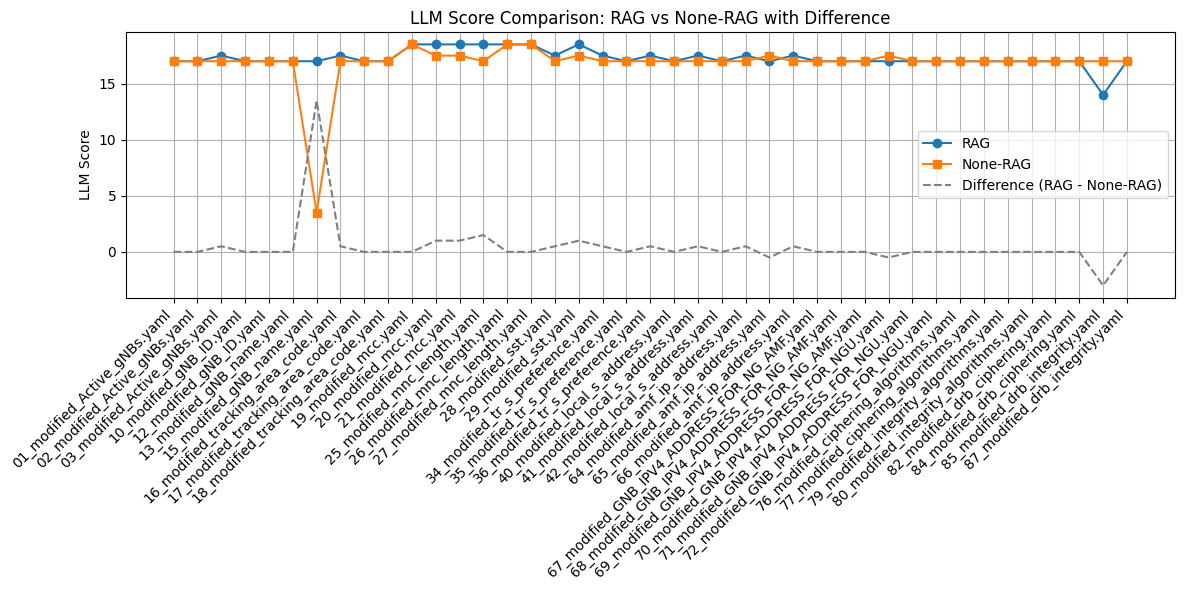

In [50]:
import json
import matplotlib.pyplot as plt

# 讀取 JSON 檔案
with open("merged_score_array.json", "r") as f:
    merged_scores = json.load(f)

# 提取資料
files = [entry["file"] for entry in merged_scores]
rag_scores = [entry["RAG"] for entry in merged_scores]
none_rag_scores = [entry["None-RAG"] for entry in merged_scores]
diff_scores = [round((r or 0) - (n or 0), 2) for r, n in zip(rag_scores, none_rag_scores)]

# 畫圖
plt.figure(figsize=(12, 6))

plt.plot(files, rag_scores, label="RAG", marker='o')
plt.plot(files, none_rag_scores, label="None-RAG", marker='s')
plt.plot(files, diff_scores, label="Difference (RAG - None-RAG)", linestyle='--', color='gray')

plt.xticks(rotation=45, ha="right")
plt.ylabel("LLM Score")
plt.title("LLM Score Comparison: RAG vs None-RAG with Difference")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("llm_score_comparison_with_diff.png")
plt.show()


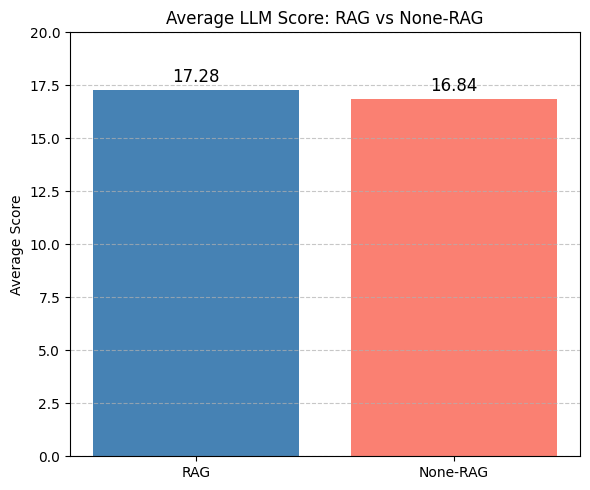

In [51]:
import matplotlib.pyplot as plt
valid_rag_scores = [s for s in rag_scores if s is not None]
valid_none_rag_scores = [s for s in none_rag_scores if s is not None]

avg_rag = round(sum(valid_rag_scores) / len(valid_rag_scores), 2)
avg_none_rag = round(sum(valid_none_rag_scores) / len(valid_none_rag_scores), 2)

# 畫平均分數直方圖
plt.figure(figsize=(6, 5))
plt.bar(["RAG", "None-RAG"], [avg_rag, avg_none_rag], color=["steelblue", "salmon"])
plt.title("Average LLM Score: RAG vs None-RAG")
plt.ylabel("Average Score")
plt.ylim(0, 20)  
plt.grid(axis="y", linestyle="--", alpha=0.7)

# 標示數值在柱子上
for i, val in enumerate([avg_rag, avg_none_rag]):
    plt.text(i, val + 0.2, f"{val:.2f}", ha="center", va="bottom", fontsize=12)

plt.tight_layout()
plt.savefig("llm_avg_score_comparison_bar.png")
plt.show()


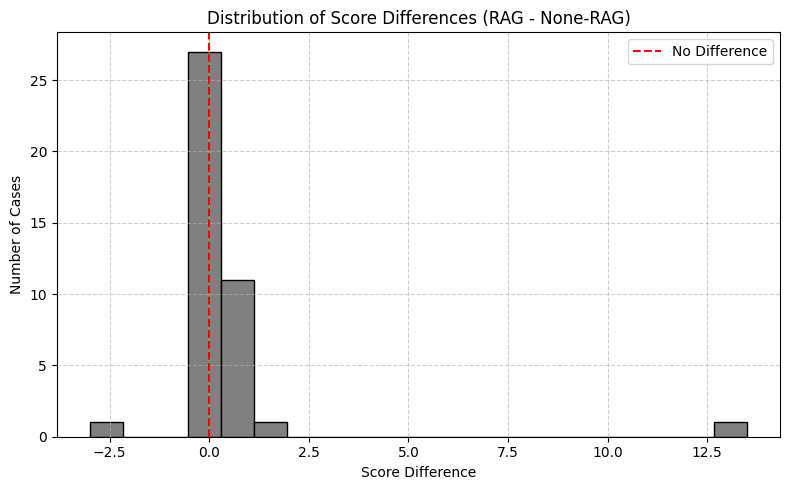

In [52]:
# 差異值分佈直方圖（RAG - None-RAG）
plt.figure(figsize=(8, 5))
plt.hist(diff_scores, bins=20, color="gray", edgecolor="black")
plt.axvline(0, color="red", linestyle="--", label="No Difference")
plt.title("Distribution of Score Differences (RAG - None-RAG)")
plt.xlabel("Score Difference")
plt.ylabel("Number of Cases")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("llm_score_difference_distribution.png")
plt.show()


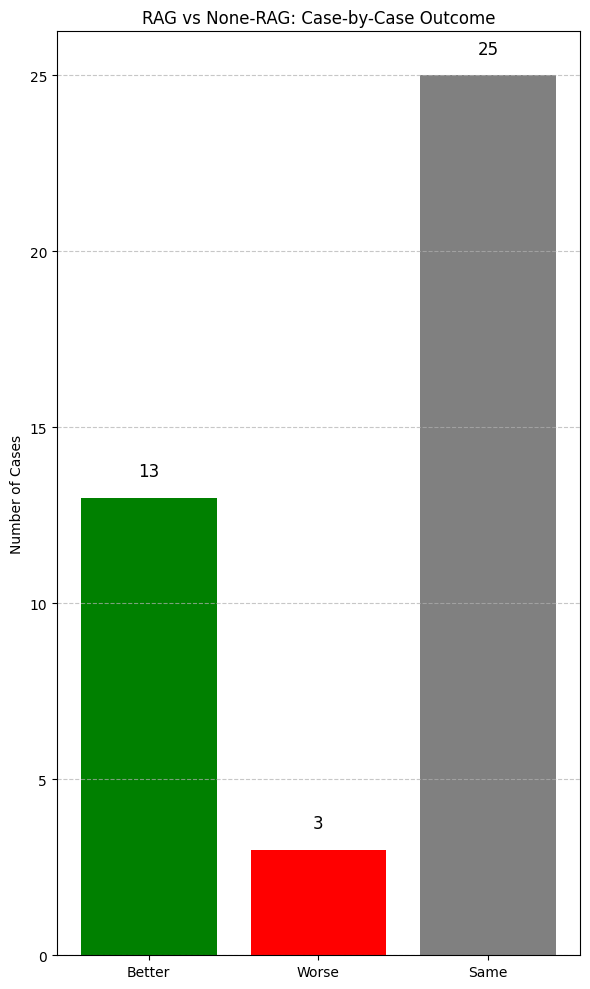

In [53]:
# 統計提升與下降的數量
better = sum(1 for diff in diff_scores if diff > 0)
worse = sum(1 for diff in diff_scores if diff < 0)
same = sum(1 for diff in diff_scores if diff == 0)

plt.figure(figsize=(6, 10))
plt.bar(["Better", "Worse", "Same"], [better, worse, same], color=["green", "red", "gray"])
plt.title("RAG vs None-RAG: Case-by-Case Outcome")
plt.ylabel("Number of Cases")
for i, val in enumerate([better, worse, same]):
    plt.text(i, val + 0.5, f"{val}", ha='center', va='bottom', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("llm_rag_improvement_stats.png")
plt.show()


In [96]:
import os
import yaml
from pathlib import Path
import json
from openai import OpenAI

# 初始化 OpenAI/NVIDIA client
client = OpenAI(
    base_url="https://integrate.api.nvidia.com/v1",
    api_key="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"
)

def extract_first_note(yaml_path):
    with open(yaml_path, "r", encoding="utf-8") as f:
        data = yaml.safe_load(f)
        if isinstance(data, list) and data:
            return data[0].get("notes", "").strip()
    return ""


In [148]:
def build_comparison_prompt(note_rag, note_none_rag):
    return f"""
You are a senior 5G systems engineer specializing in OpenAirInterface (OAI) network debugging and configuration analysis.

You will compare two debug notes, each describing a root cause analysis for a 5G configuration failure. Your task is to **evaluate each note across four dimensions** and determine **which note is better overall**.

Evaluate both notes across the following four criteria (0–2.5 points each):

1. **Clarity** – Is the note clearly written and logically structured for technical readers?
2. **System Behavior Interpretation** – Does the note provide a technically sound interpretation of the logs, error messages, or protocol failures?
3. **Standard Compliance & Reference** – Does the note reference relevant 3GPP or O-RAN specifications (e.g., TS 38.331, 38.401) and interpret them correctly?
4. **Config Relevance** – Are the configuration parameters properly linked to the log behavior and identified as the probable cause?

Each note should get a **total score between 0 and 10**.

After scoring both notes:
- Indicate which note is overall better by assigning the `"winner"` key as either `"rag"`, `"none_rag"`, or `"tie"`.
- Provide a `"reason"` explaining the decision in 1–3 sentences.

⚠️ Only use `"tie"` if both notes are equal **across all four criteria**. Favor the one with more technical insight, even if slightly more verbose.

📤 Return your result as a raw JSON (no code blocks, no markdown), following **this exact format**:

{{
  "scores": {{
    "rag": {{
      "clarity": <0–10>,
      "System_Behavior_Interpretation": <0–10>,
      "standard_reference": <0–10>,
      "config_relevance": <0–10>,
      "total": <0–40>
    }},
    "none_rag": {{
      "clarity": <0–10>,
      "System_Behavior_Interpretation": <0–10>,
      "standard_reference": <0–10>,
      "config_relevance": <0–10>,
      "total": <0–40>
    }}
  }},
  "winner": "<rag | none_rag | tie>",
  "reason": "<brief explanation>"
}}

🔹 Note from RAG:
""{note_rag}""

🔸 Note from None-RAG:
""{note_none_rag}""

"""

In [130]:
import json
import re

def call_comparison_llm(prompt: str) -> dict:
    response = client.chat.completions.create(
        model="microsoft/phi-4-multimodal-instruct",
        messages=[{"role": "user", "content": prompt}],
        temperature=0,
        top_p=0.7,
        max_tokens=512,
        stream=False
    )
    raw = response.choices[0].message.content.strip()

    # 嘗試先直接解析（萬一模型沒包裹就用這個）
    try:
        return json.loads(raw)
    except:
        # 抓取 ```json ... ``` 中的內容
        match = re.search(r"```json\s*({.*?})\s*```", raw, re.DOTALL)
        if match:
            json_str = match.group(1)
            try:
                return json.loads(json_str)
            except Exception as e:
                return {"winner": "error", "reason": f"Failed to parse extracted JSON: {json_str}"}
        else:
            return {"winner": "error", "reason": f"Failed to parse: {raw}"}


In [149]:
import json
from pathlib import Path
from collections import Counter

# 設定資料夾路徑與儲存檔案位置
rag_dir = Path("/home/aiml/johnson/auto_gen_debug_yaml/debug_yaml_dir/rag")
none_rag_dir = Path("/home/aiml/johnson/auto_gen_debug_yaml/debug_yaml_dir/none_rag")
output_path = Path("comparison_results.json")

# 初始化結果與計數器
results = []
winner_counter = Counter()
completed_files = set()


# ✅ 若有舊的 JSON 檔案，直接清除內容或覆寫（非必要但可防錯）
if output_path.exists():
    output_path.unlink()  # 刪除舊檔案（或可留空行為）


# 開始比對
for rag_file in rag_dir.glob("*.yaml"):
    core_name = rag_file.name.replace("rag_debug_", "")
    if core_name in completed_files:
        print(f"⏭️ Skipping already processed: {core_name}")
        continue

    none_rag_file = none_rag_dir / f"none_rag_debug_{core_name}"
    if not none_rag_file.exists():
        print(f"❌ No match for {rag_file.name}")
        continue

    note_rag = extract_first_note(rag_file)
    note_none_rag = extract_first_note(none_rag_file)

    if not note_rag or not note_none_rag:
        print(f"⚠️ Missing note in {core_name}")
        continue

    prompt = build_comparison_prompt(note_rag, note_none_rag)
    print(f"🔍 Comparing {core_name}")
    result = call_comparison_llm(prompt)
    print(f"Result for {core_name}: {result}")
    print("-" * 100)
    print("\n")

    winner_raw = result.get("winner", "error")
    # 統一格式，例如：none_rag、rag、tie、error
    winner = winner_raw.lower().replace("-", "_")
    winner_counter[winner] += 1

    entry = {
        "file": core_name,
        "winner": winner,
        "reason": result.get("reason", ""),
        "scores": result.get("scores", {})  # 包含 rag 與 none_rag 的所有細項分數
    }

    results.append(entry)

    # 即時寫入結果
    with open(output_path, "w", encoding="utf-8") as f:
        json.dump(results, f, indent=2, ensure_ascii=False)




🔍 Comparing 40_modified_local_s_address.yaml
Result for 40_modified_local_s_address.yaml: {'scores': {'rag': {'clarity': 2.5, 'System_Behavior_Interpretation': 2.0, 'standard_reference': 2.5, 'config_relevance': 2.0, 'total': 9.5}, 'none_rag': {'clarity': 2.0, 'System_Behavior_Interpretation': 2.5, 'standard_reference': 2.0, 'config_relevance': 2.5, 'total': 9.0}}, 'winner': 'rag', 'reason': 'The RAG note provides a clearer and more structured analysis, with better reference to the relevant 3GPP specifications and a more direct link between the configuration parameters and the observed behavior.'}
----------------------------------------------------------------------------------------------------


🔍 Comparing 36_modified_tr_s_preference.yaml
Result for 36_modified_tr_s_preference.yaml: {'scores': {'rag': {'clarity': 8, 'System_Behavior_Interpretation': 7, 'standard_reference': 9, 'config_relevance': 8, 'total': 32}, 'none_rag': {'clarity': 9, 'System_Behavior_Interpretation': 8, 'stan

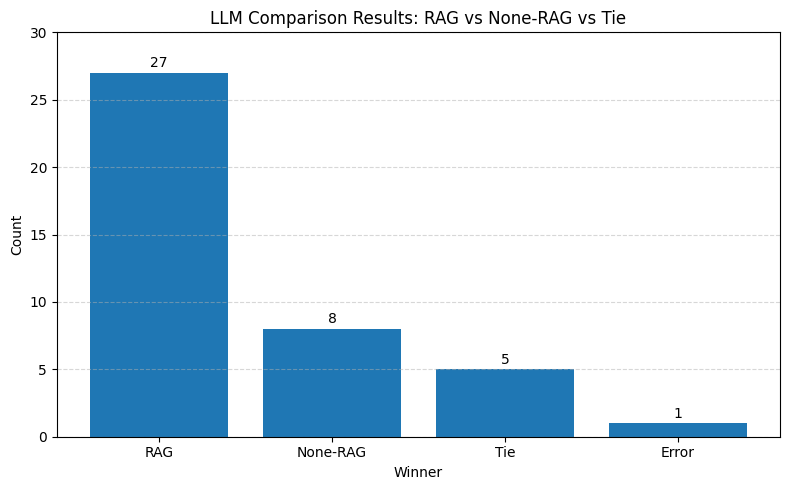

In [150]:
import json
from collections import Counter
from pathlib import Path
import matplotlib.pyplot as plt

# 讀取 JSON 路徑（自行修改）
json_path = Path("comparison_results.json")

# 載入 JSON 資料
with open(json_path, "r", encoding="utf-8") as f:
    data = json.load(f)

# 計算每種類型的次數
winner_counter = Counter()
for entry in data:
    winner_raw = entry.get("winner", "error")
    winner = winner_raw.lower().replace("-", "_")
    winner_counter[winner] += 1

# 類別與數量
labels = ["RAG", "None-RAG", "Tie", "Error"]
values = [
    winner_counter.get("rag", 0),
    winner_counter.get("none_rag", 0),
    winner_counter.get("tie", 0),
    winner_counter.get("error", 0)
]

# 繪製長條圖
plt.figure(figsize=(8, 5))
bars = plt.bar(labels, values)

# 顯示數值在長條上
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.2, str(height), ha='center', va='bottom')

# 標題與軸標籤
plt.title("LLM Comparison Results: RAG vs None-RAG vs Tie")
plt.xlabel("Winner")
plt.ylabel("Count")
plt.ylim(0, max(values) + 3)
plt.grid(axis="y", linestyle="--", alpha=0.5)

# 顯示圖形
plt.tight_layout()
plt.show()


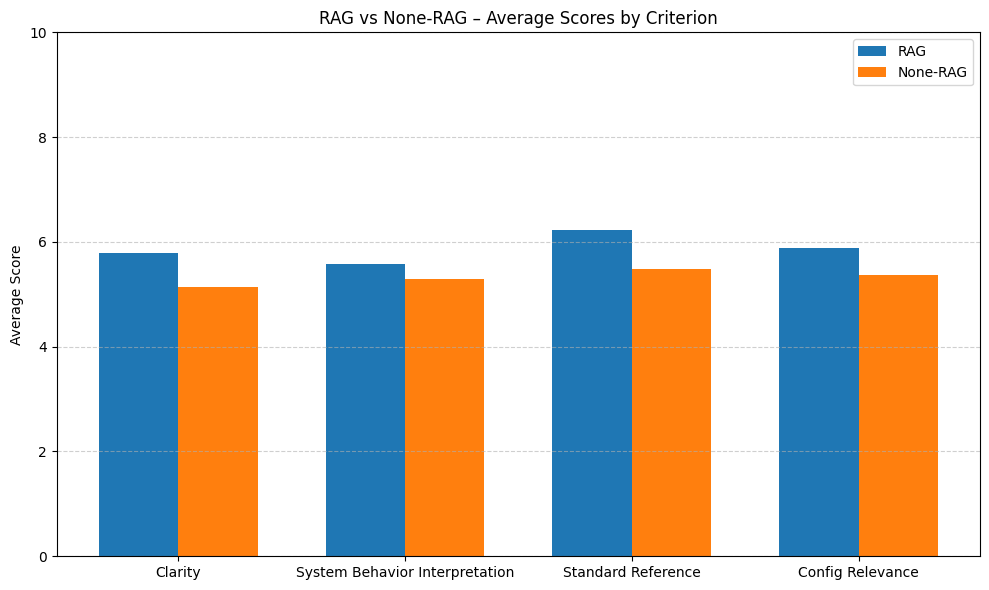

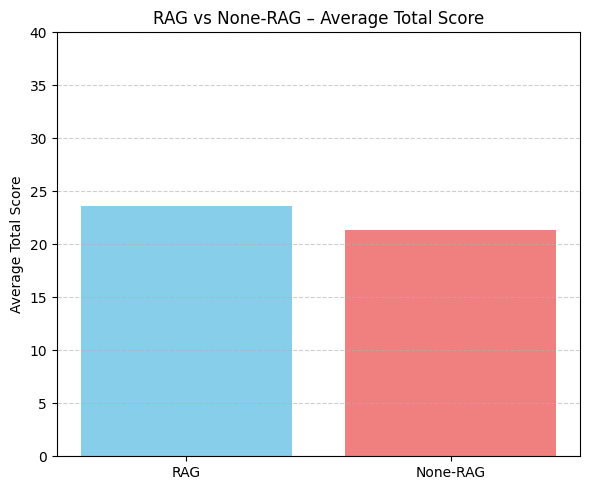

In [153]:
import json
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

# 路徑設定
json_path = Path("/home/aiml/johnson/auto_gen_debug_yaml/comparison_results.json")

# 讀取 JSON
with open(json_path, "r", encoding="utf-8") as f:
    results = json.load(f)

# 建立 DataFrame
data = []
for entry in results:
    try:
        file = entry["file"]
        winner = entry.get("winner", "unknown")
        scores = entry.get("scores", {})
        rag = scores.get("rag", {})
        none_rag = scores.get("none_rag", {})

        data.append({
            "file": file,
            "winner": winner,
            "RAG_Clarity": rag.get("clarity", 0),
            "RAG_TechAcc": rag.get("System_Behavior_Interpretation", 0),
            "RAG_StdRef": rag.get("standard_reference", 0),
            "RAG_ConfigRel": rag.get("config_relevance", 0),
            "RAG_Total": rag.get("total", 0),
            "NoneRAG_Clarity": none_rag.get("clarity", 0),
            "NoneRAG_TechAcc": none_rag.get("System_Behavior_Interpretation", 0),
            "NoneRAG_StdRef": none_rag.get("standard_reference", 0),
            "NoneRAG_ConfigRel": none_rag.get("config_relevance", 0),
            "NoneRAG_Total": none_rag.get("total", 0),
        })
    except Exception as e:
        print(f"⚠️ Failed to process entry for file {entry.get('file', 'unknown')}: {e}")

df = pd.DataFrame(data)

# 計算平均分數
avg_scores = {
    "RAG": {
        "Clarity": df["RAG_Clarity"].mean(),
        "System Behavior Interpretation": df["RAG_TechAcc"].mean(),
        "Standard Reference": df["RAG_StdRef"].mean(),
        "Config Relevance": df["RAG_ConfigRel"].mean(),
        "Total": df["RAG_Total"].mean()
    },
    "None-RAG": {
        "Clarity": df["NoneRAG_Clarity"].mean(),
        "System Behavior Interpretation": df["NoneRAG_TechAcc"].mean(),
        "Standard Reference": df["NoneRAG_StdRef"].mean(),
        "Config Relevance": df["NoneRAG_ConfigRel"].mean(),
        "Total": df["NoneRAG_Total"].mean()
    }
}

# 分離出各項與總分
detailed_metrics = ["Clarity", "System Behavior Interpretation", "Standard Reference", "Config Relevance"]
rag_detailed_scores = [avg_scores["RAG"][metric] for metric in detailed_metrics]
none_rag_detailed_scores = [avg_scores["None-RAG"][metric] for metric in detailed_metrics]

# 圖1：各項細項指標比較
x = range(len(detailed_metrics))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar([i - width/2 for i in x], rag_detailed_scores, width=width, label="RAG")
plt.bar([i + width/2 for i in x], none_rag_detailed_scores, width=width, label="None-RAG")

plt.xticks(x, detailed_metrics)
plt.ylabel("Average Score")
plt.title("RAG vs None-RAG – Average Scores by Criterion")
plt.ylim(0, 10)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# 圖2：Total 比較
plt.figure(figsize=(6, 5))
plt.bar(["RAG", "None-RAG"],
        [avg_scores["RAG"]["Total"], avg_scores["None-RAG"]["Total"]],
        color=["skyblue", "lightcoral"])
plt.ylabel("Average Total Score")
plt.title("RAG vs None-RAG – Average Total Score")
plt.ylim(0, 40)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()
